In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot

import dsets_ch14
import model_ch14


In [2]:
ds = dsets_ch14.MalignantLunaDataset(val_stride=10, isValSet_bool=True)  # <1>
nodules = ds.ben_list + ds.mal_list
is_mal = torch.tensor([n.isMal_bool for n in nodules])  # <2>
diam = torch.tensor([n.diameter_mm for n in nodules])
num_mal = is_mal.sum()  # <3>
num_ben = len(is_mal) - num_mal

2024-11-03 19:05:49,285 INFO     pid:31767 dsets_ch14:319:__init__ <dsets_ch14.MalignantLunaDataset object at 0x7e92c19c6490>: 6312 validation samples, 6301 neg, 11 pos, unbalanced ratio


In [4]:
threshold = torch.linspace(diam.max(), diam.min(), 100)

In [5]:
predictions = diam[None] >= threshold[:, None]  # <1>
tp_diam = (predictions & is_mal[None]).sum(1).float() / num_mal  # <2>
fp_diam = (predictions & ~is_mal[None]).sum(1).float() / num_ben

In [6]:
fp_diam_diff = fp_diam[1:] - fp_diam[:-1]
tp_diam_avg = (tp_diam[1:] + tp_diam[:-1]) / 2
auc_diam = (fp_diam_diff * tp_diam_avg).sum()

In [7]:
fp_fill = torch.ones((fp_diam.shape[0] + 1,))
fp_fill[:-1] = fp_diam

tp_fill = torch.zeros((tp_diam.shape[0] + 1,))
tp_fill[:-1] = tp_diam

print(threshold)
print(fp_diam)
print(tp_diam)

tensor([19.6539, 19.5030, 19.3521, 19.2013, 19.0504, 18.8995, 18.7486, 18.5978,
        18.4469, 18.2960, 18.1451, 17.9943, 17.8434, 17.6925, 17.5416, 17.3908,
        17.2399, 17.0890, 16.9382, 16.7873, 16.6364, 16.4855, 16.3347, 16.1838,
        16.0329, 15.8820, 15.7312, 15.5803, 15.4294, 15.2785, 15.1277, 14.9768,
        14.8259, 14.6751, 14.5242, 14.3733, 14.2224, 14.0716, 13.9207, 13.7698,
        13.6189, 13.4681, 13.3172, 13.1663, 13.0154, 12.8646, 12.7137, 12.5628,
        12.4120, 12.2611, 12.1102, 11.9593, 11.8085, 11.6576, 11.5067, 11.3558,
        11.2050, 11.0541, 10.9032, 10.7523, 10.6015, 10.4506, 10.2997, 10.1488,
         9.9980,  9.8471,  9.6962,  9.5454,  9.3945,  9.2436,  9.0927,  8.9419,
         8.7910,  8.6401,  8.4892,  8.3384,  8.1875,  8.0366,  7.8857,  7.7349,
         7.5840,  7.4331,  7.2823,  7.1314,  6.9805,  6.8296,  6.6788,  6.5279,
         6.3770,  6.2261,  6.0753,  5.9244,  5.7735,  5.6226,  5.4718,  5.3209,
         5.1700,  5.0192,  4.8683,  4.71

In [8]:
for i in range(threshold.shape[0]):
    print(i, threshold[i], fp_diam[i], tp_diam[i])

0 tensor(19.6539) tensor(0.) tensor(0.2000)
1 tensor(19.5030) tensor(0.) tensor(0.2000)
2 tensor(19.3521) tensor(0.) tensor(0.2000)
3 tensor(19.2013) tensor(0.) tensor(0.2000)
4 tensor(19.0504) tensor(0.) tensor(0.2000)
5 tensor(18.8995) tensor(0.) tensor(0.2000)
6 tensor(18.7486) tensor(0.) tensor(0.2000)
7 tensor(18.5978) tensor(0.) tensor(0.2000)
8 tensor(18.4469) tensor(0.) tensor(0.2000)
9 tensor(18.2960) tensor(0.) tensor(0.2000)
10 tensor(18.1451) tensor(0.) tensor(0.2000)
11 tensor(17.9943) tensor(0.) tensor(0.2000)
12 tensor(17.8434) tensor(0.) tensor(0.2000)
13 tensor(17.6925) tensor(0.) tensor(0.4000)
14 tensor(17.5416) tensor(0.) tensor(0.4000)
15 tensor(17.3908) tensor(0.) tensor(0.4000)
16 tensor(17.2399) tensor(0.) tensor(0.4000)
17 tensor(17.0890) tensor(0.) tensor(0.4000)
18 tensor(16.9382) tensor(0.) tensor(0.4000)
19 tensor(16.7873) tensor(0.) tensor(0.4000)
20 tensor(16.6364) tensor(0.) tensor(0.4000)
21 tensor(16.4855) tensor(0.) tensor(0.4000)
22 tensor(16.3347) t

diam: 10.3, x: 0.17, y: 0.8
diam: 6.38, x: 0.5, y: 1.0


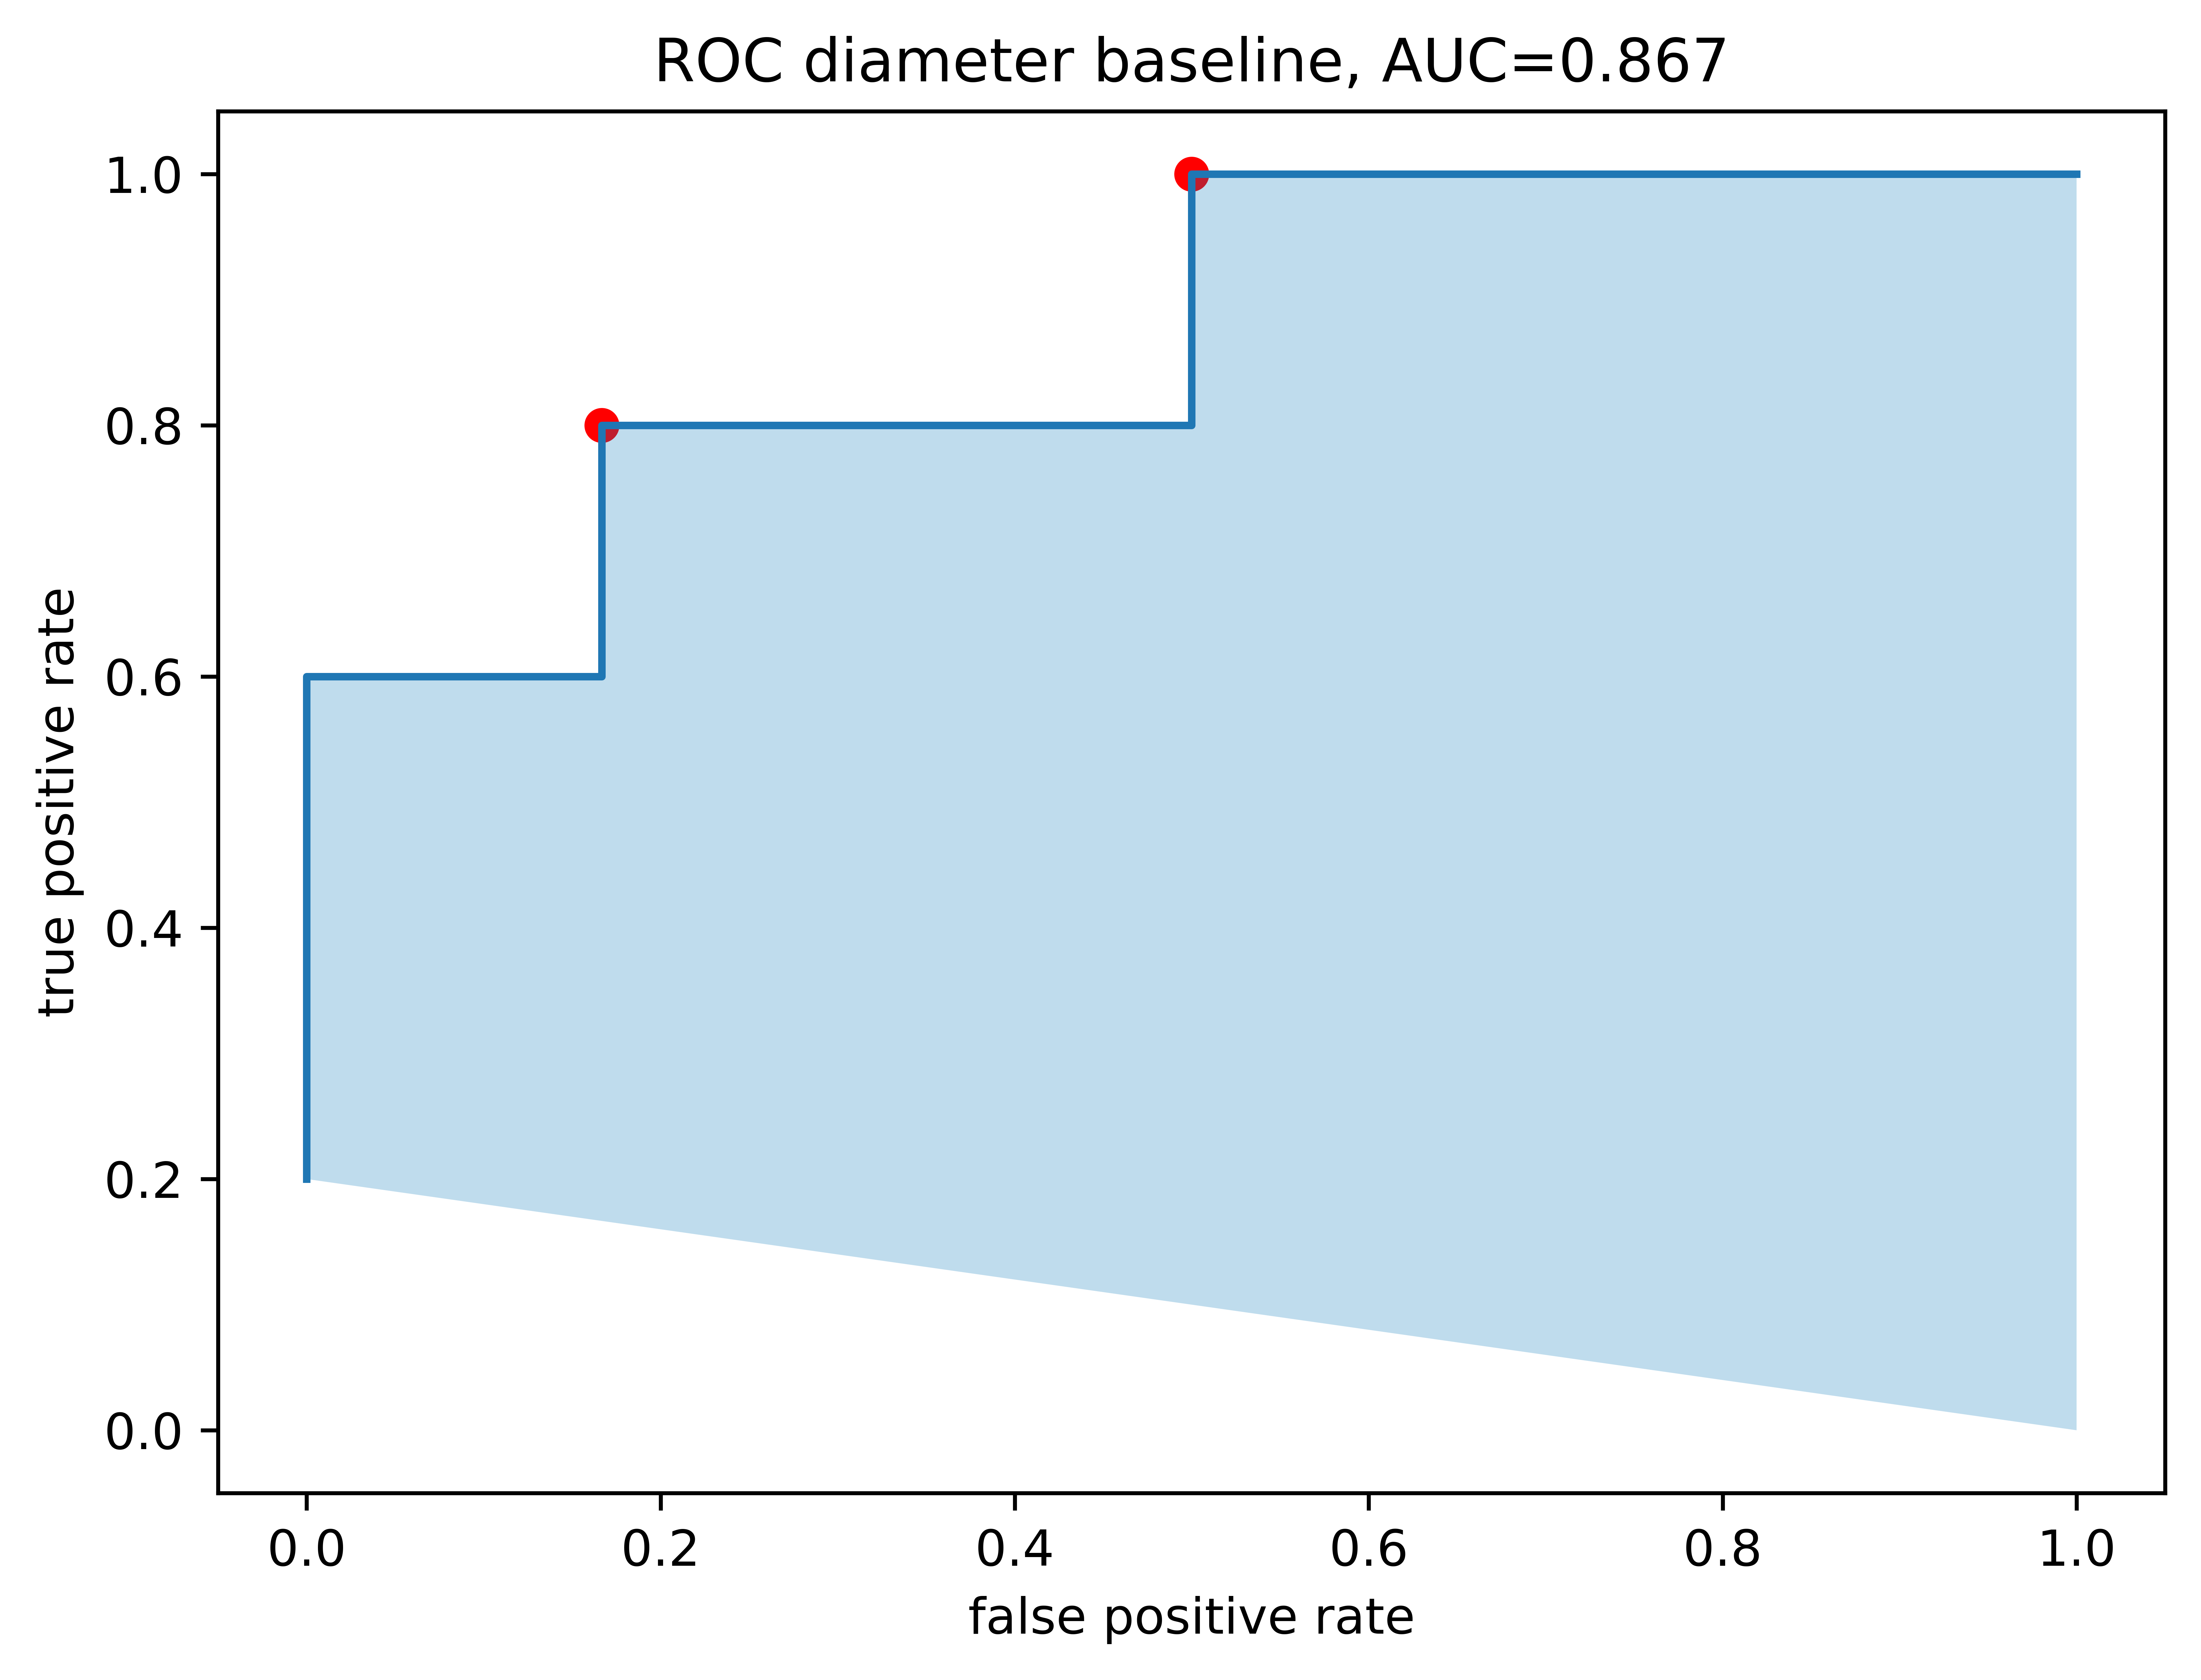

In [9]:
pyplot.figure(figsize=(7, 5), dpi=1200)
for i in [62, 88]:
    pyplot.scatter(fp_diam[i], tp_diam[i], color="red")
    print(
        f"diam: {round(threshold[i].item(), 2)}, x: {round(fp_diam[i].item(), 2)}, y: {round(tp_diam[i].item(), 2)}"
    )
pyplot.fill(fp_fill, tp_fill, facecolor="#0077bb", alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f"diameter baseline, AUC={auc_diam:.3f}")
pyplot.title(f"ROC diameter baseline, AUC={auc_diam:.3f}")
pyplot.ylabel("true positive rate")
pyplot.xlabel("false positive rate")
pyplot.savefig("roc_diameter_baseline.png")

In [11]:
model = model_ch14.LunaModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sd = torch.load(
    "data-unversioned/part2/models/p2ch14/cls_2024-11-03_10.59.43_nodule-nonnodule.best.state"
)
model.load_state_dict(sd["model_state"])
model.to(device)
model.eval()

/tmp/ipykernel_31767/1104052468.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(


LunaModel(
  (tail_batchnorm): BatchNorm3d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (block1): LunaBlock(
    (conv1): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): LunaBlock(
    (conv1): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu2): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): LunaBlock(
    (conv1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv3d(32, 32, kernel_siz

In [12]:
ds = dsets_ch14.MalignantLunaDataset(val_stride=10, isValSet_bool=True)
dl = torch.utils.data.DataLoader(ds, batch_size=32, num_workers=4)

2024-11-03 19:07:43,820 INFO     pid:31767 dsets_ch14:319:__init__ <dsets_ch14.MalignantLunaDataset object at 0x7e926d059710>: 6312 validation samples, 6301 neg, 11 pos, unbalanced ratio


In [13]:
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)
    truth += (label[:, 1] > 0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

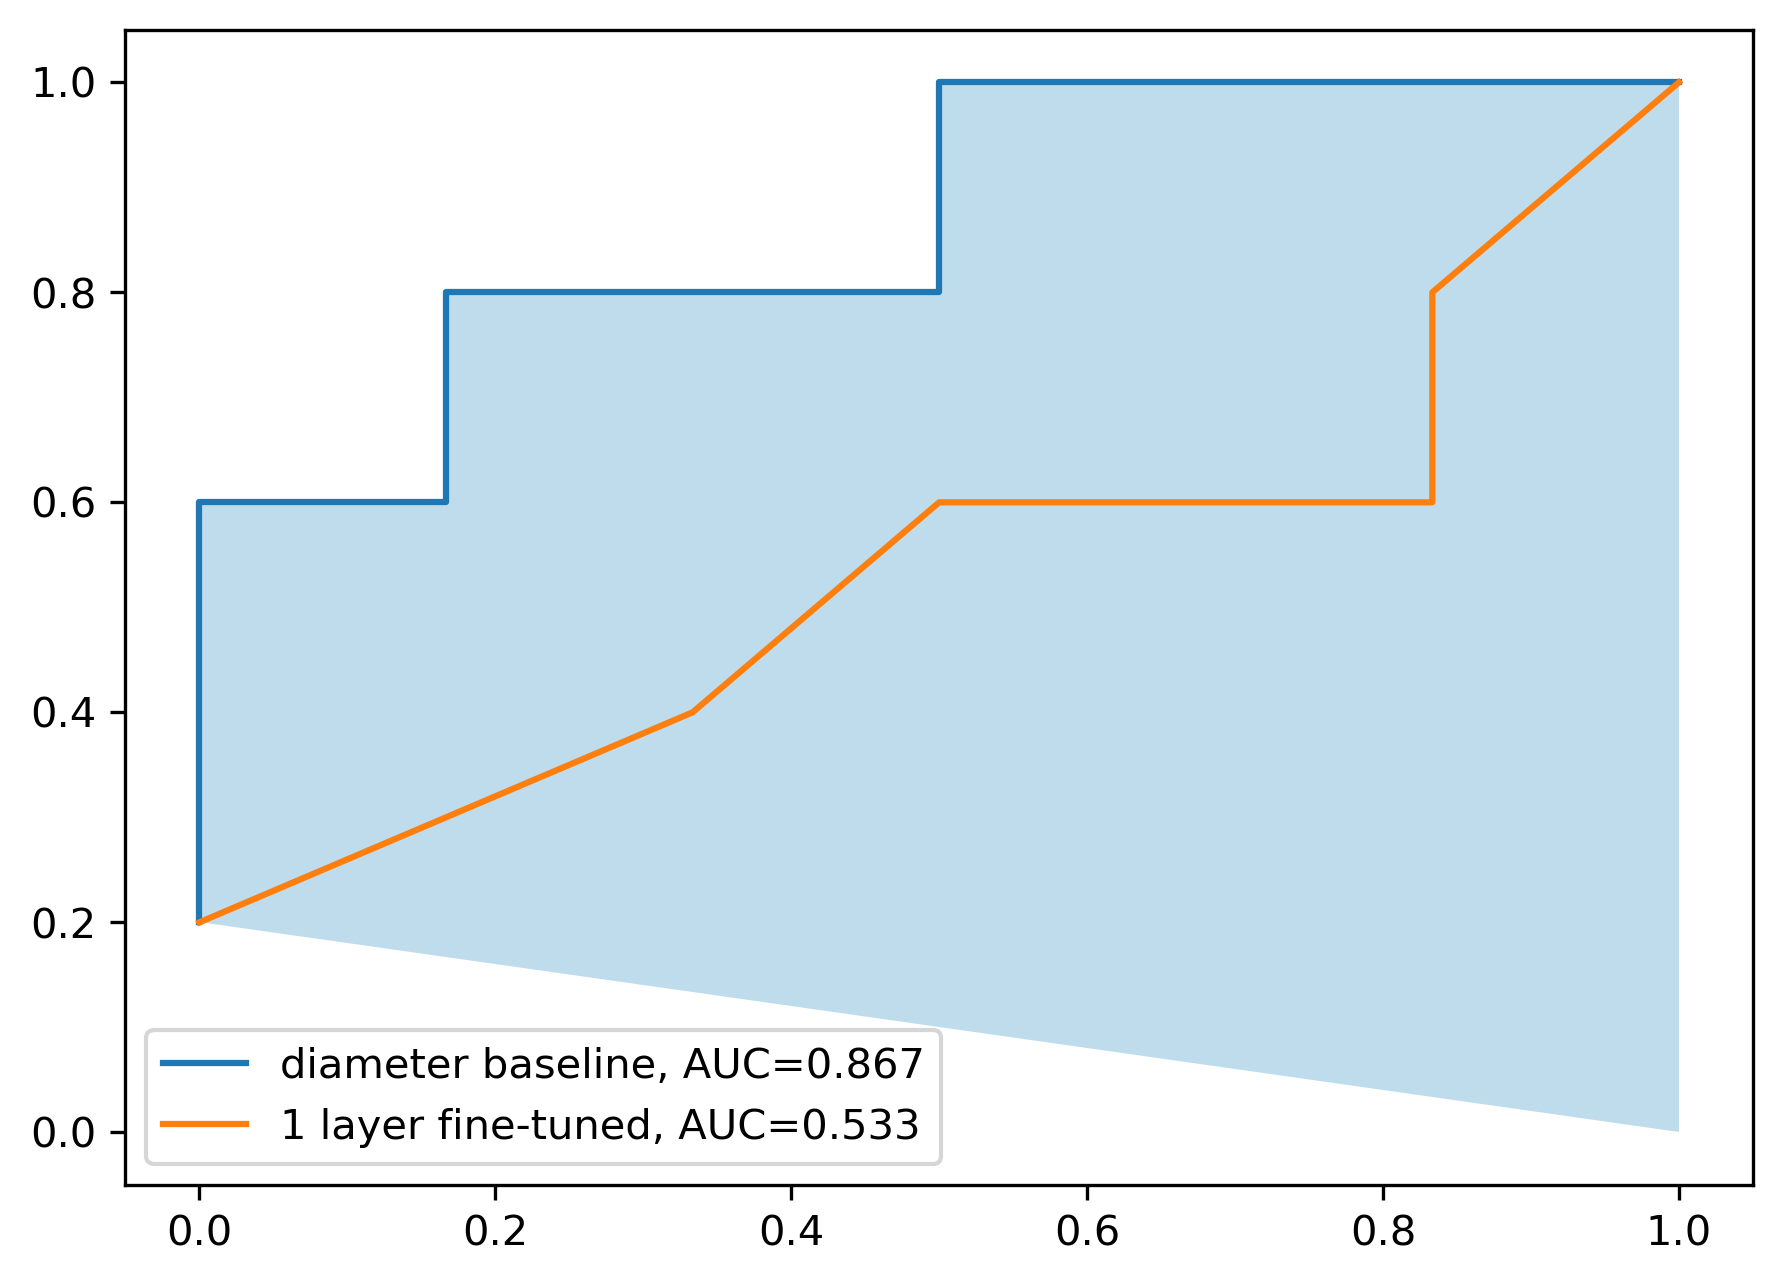

In [15]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0, 100)
tp_finetune = ((preds[None] >= threshold[:, None]) & truth[None]).sum(
    1
).float() / num_mal
fp_finetune = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(
    1
).float() / num_ben
fp_finetune_diff = fp_finetune[1:] - fp_finetune[:-1]
tp_finetune_avg = (tp_finetune[1:] + tp_finetune[:-1]) / 2
auc_finetune = (fp_finetune_diff * tp_finetune_avg).sum()

pyplot.figure(figsize=(7, 5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor="#0077bb", alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f"diameter baseline, AUC={auc_diam:.3f}")
pyplot.plot(
    fp_finetune, tp_finetune, label=f"1 layer fine-tuned, AUC={auc_finetune:.3f}"
)
pyplot.legend()
pyplot.savefig("roc_finetune.png")

In [13]:
if 1:
    fn = "data/part2/models/cls_2020-02-08_00.19.45_finetune-depth2.best.state"
    model = model_ch14.LunaModel()
    sd = torch.load(fn, map_location="cpu")["model_state"]
    model.load_state_dict(sd)
    model.to(device)
    model.eval()

In [14]:
model.eval()
preds = []
truth = []
for inp, label, _, _, _ in dl:
    inp = inp.to(device)
    truth += (label[:, 1] > 0).tolist()
    with torch.no_grad():
        _, p = model(inp)
        preds += p[:, 1].tolist()
truth = torch.tensor(truth)
preds = torch.tensor(preds)

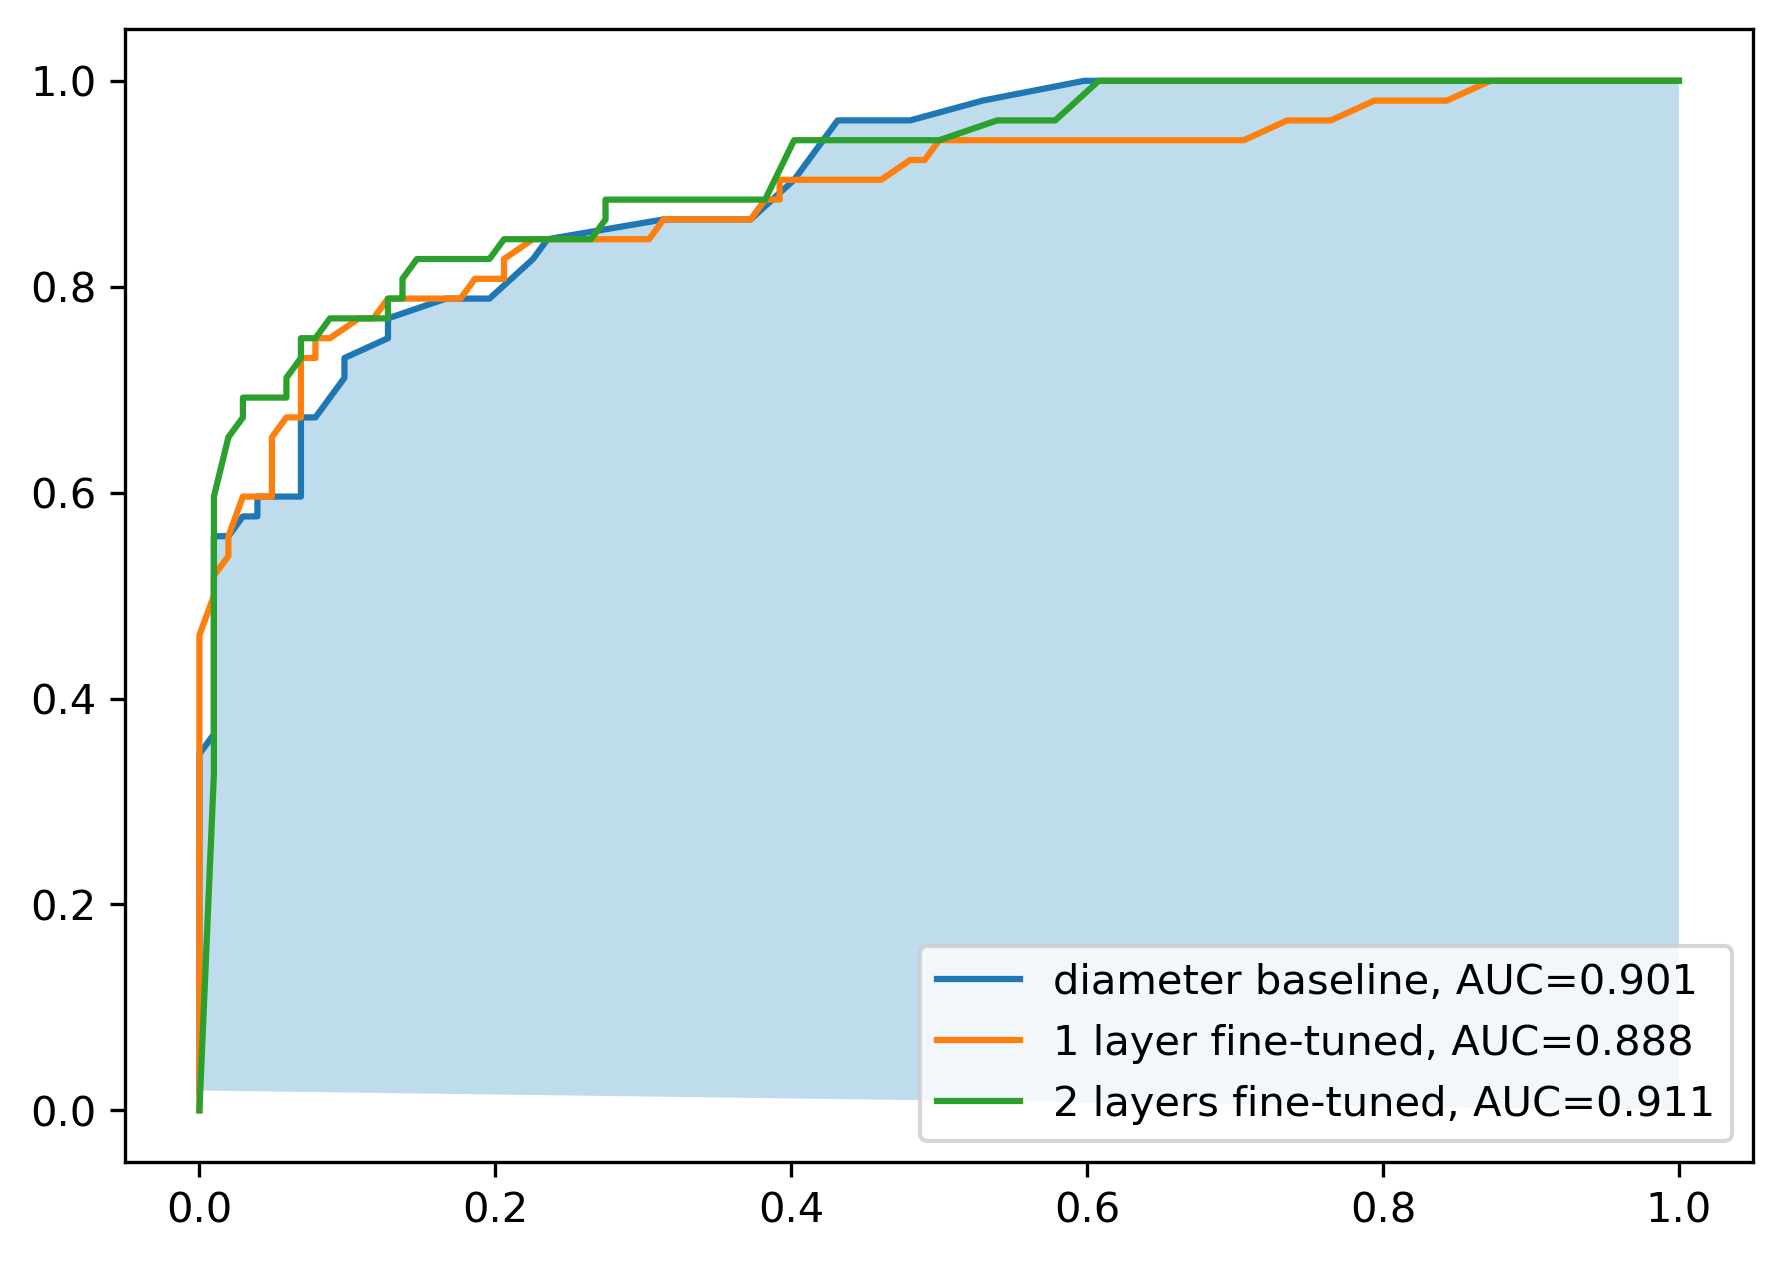

In [15]:
num_mal = truth.sum()
num_ben = len(truth) - num_mal
threshold = torch.linspace(1, 0)
tp = ((preds[None] >= threshold[:, None]) & truth[None]).sum(1).float() / num_mal
fp = ((preds[None] >= threshold[:, None]) & ~truth[None]).sum(1).float() / num_ben

fp_diff = fp[1:] - fp[:-1]
tp_avg = (tp[1:] + tp[:-1]) / 2
auc_modified = (fp_diff * tp_avg).sum()

pyplot.figure(figsize=(7, 5), dpi=300)
pyplot.fill(fp_fill, tp_fill, facecolor="#0077bb", alpha=0.25)
pyplot.plot(fp_diam, tp_diam, label=f"diameter baseline, AUC={auc_diam:.3f}")
pyplot.plot(
    fp_finetune, tp_finetune, label=f"1 layer fine-tuned, AUC={auc_finetune:.3f}"
)
pyplot.plot(fp, tp, label=f"2 layers fine-tuned, AUC={auc_modified:.3f}")
pyplot.legend()
pyplot.savefig("roc_modified.png")